<a href="https://colab.research.google.com/github/AnnaZhuravleva/HSE/blob/master/course%204/sem04/sem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа
## Ранжирование с помощью ML


![](https://avatars.mds.yandex.net/get-research/1677227/2a00000168a82fc9b0eac19e430b8454a656/orig)


Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

### Подходы к решению задачи ранжирования
Существуют 3 основных подхода к ранжированию, различие между которыми заключается в том, на какую функцию потерь они опираются:
  
1. **Поточечный подход (pointwise)**. В этом подходе предполагается, что каждой паре запрос-документ поставлена в соответствие численная оценка. Задача обучения ранжированию сводится к построению регрессии: для каждой отдельной пары запрос-документ необходимо предсказать её оценку.

2. **Попарный подход (pairwise)**. В таком подходе обучение ранжированию сводится к построению бинарного классификатора, которому на вход поступают два документа, соответствующих одному и тому же запросу, и требуется определить, какой из них лучше. Другими словами, функция потерь штрафует модель, если отранжированная этой моделью пара документов оказалась в неправильном порядке.

3. **Списочный подход (listwise)**. Его суть заключается в построении модели, на вход которой поступают сразу все документы, соответствующие запросу, а на выходе получается их перестановка.


Будем использовать самый простой подход - поточечный.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.

Для одного запроса DCG считается следующим образом:
$$ DCG(Q) = \sum_{i=1}^{numpos}\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$
где
>$numpos$ — количество документов в поисковой выдаче, среди которых мы оценимваем качество (например, в предудыщих заданиях *num_pos* был равен 5)  
$rel_i$ — оценка релевантности документа, находящегося на i-той позиции   
   

Нормализованный вариант *nDCG* получается делением *DCG* на максимальное из его значений:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$
> *IDCG* — наибольшее из возможных значение *DCG* 






Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

# Погнали
###  **Задача: предсказать оценку релевантности для запросов тестового датасета**


Мы будем работать на данных с конкурса [Интернет-математика 2009](https://academy.yandex.ru/events/data_analysis/grant2009/). По ссылке можно прочитать описание данных.      

Данные
> Данные разбиты на две выборки – обучающая выборка imat2009_learning.txt с известными оценками близости запроса и документа и тестовая выборка с неизвестными близостями imat2009_test.txt  

Обучающая выборка
> Данные для обучения содержат **97 290 строк**, которые соответствуют **9 124 запросам**  
Каждая строка соответствует паре «запрос-документ»    

Признаки
>Каждой паре «запрос-документ» соответствуют значения **245 признаков**. Формат хранения feat_num:value. Если значение признака равно 0, то он опускается.     
В комментариях в конце каждой строки указан **идентификатор запроса**.   
Файл с обучающей выборкой содержит **оценку релевантности**, значения из диапазона **[0, 4]** (4 – «высокая релевантность», 0 – «нерелевантно»).   


### DATA

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/Colab Notebooks/infosearch/sem4/'
sys.path.append(project_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# LOAD TRAIN DATA
file_learning = '/content/drive/My Drive/Colab Notebooks/infosearch/sem4/imat2009-datasets/imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test = '/content/drive/My Drive/Colab Notebooks/infosearch/sem4/imat2009-datasets/imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()


In [3]:
len(train_data), len(test_data)

(97290, 115643)

Структура данных следующая - первый элемент в строке - это оценка близости запроса и документа, дальше идут признаки документа, а последний элемент строки - это id запроса:

> RELEVANCE      feature:value feature:value ... feature:value     # QUERY_ID

In [4]:
train_data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

В test_data все оценки релевантности скрыты, поскольку этот набор данных использовался для проверки качества работы алгоритма в конкурсе. Нам эти данные не нужны, дальше работаем только с **train_data**.

Для проверки качества будущей модели надо разбить обучающую выборку на обучение и валидацию в соотношении 70 / 30

Внимание: разбивать необходимо **множество запросов QUERY_ID**, а не строчки датасета, чтобы в выборке находилась вся информация по запросу

Для этого вам надо:
1. собрать все запросы для каждого QUERY_ID

```
{
query_id : [
    RELEVANCE feature:value ... feature:value,
    ...
],
...
}
```

При этом я бы сразу собирала не сами данные, а номер строки в матрице данных
```
{
query_id : [
    line_num, line_num, ... line_num
],
...
}
```
2. собрать матрицу данных, размер вектора равен числу признаков = 245
```
data = np.zeros((len(train_data), feats_num), dtype=np.float32) 
```

3. собрать вектор с оценками релевантности, его размер равен размеру train_data

In [0]:
import numpy as np
from collections import defaultdict
from math import floor

labels = [] 
queries_lines_info = defaultdict(list) 

train_data = train_data
data = np.zeros((len(train_data), 245), dtype=np.float32) 


#YOUR CODE HERE
for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = floor(float(line_data[0]))
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id)-1
        
        data[i, feat_id] = feat_value


In [23]:
len(queries_lines_info)

9124

In [0]:
queries = queries_lines_info

In [0]:
# check
assert data.shape == (len(train_data), 245)
assert len(queries.keys()) == 9124
assert len(labels) == len(train_data)

Разделим запросы из *queries_lines_info.keys()* на обучающую *train_queries_ids* и валидационную выборки *test_queries_ids* (70/30)

In [0]:
from sklearn.model_selection import train_test_split

#YOUR CODE HERE
queries_ids = list(queries_lines_info.keys())
train_queries_ids, test_queries_ids = train_test_split(queries_ids, test_size=0.3, random_state=42)


In [0]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

 > Теперь у нас есть:  
 1) айдишники запросов для обучения и валидации **queries_id_train, queries_id_test**   
 2) матрица данных **data**   
 3) словарь **queries** с информацией о том, какие строчки в этой матрице соответствуют какому айдишнику  
 
 С помощью этих данных разделите матрицу data на матрицы **X_train, y_train, X_test, y_test**

In [28]:
# изи пизи способ получить несколько строк матрицы по их id данные матрицы
data_example = np.array(
    [
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]
    ]
)

data_example[[0, 3]]

array([[0, 0, 0],
       [3, 3, 3]])

In [0]:
# разбиваем номера строк исходной матрицы на train и test

train_queries_lines_info = []
test_queries_lines_info = []

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]
    
for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]

labels = np.array(labels)

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [0]:
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

In [39]:
list(test_queries_lines_info)

[32350,
 32351,
 32352,
 32353,
 32354,
 32355,
 32356,
 32357,
 32358,
 32359,
 32360,
 32361,
 32362,
 32363,
 32364,
 32365,
 47563,
 47564,
 47565,
 47566,
 47567,
 47568,
 47569,
 47570,
 47571,
 47572,
 32723,
 32724,
 32725,
 32726,
 32727,
 32728,
 32729,
 34753,
 34754,
 34755,
 34756,
 34757,
 34758,
 34759,
 34760,
 89971,
 89972,
 89973,
 89974,
 89975,
 89976,
 89977,
 89978,
 89979,
 89980,
 89981,
 89982,
 25602,
 25603,
 25604,
 25605,
 25606,
 25607,
 25608,
 25609,
 25610,
 25611,
 25612,
 5175,
 5176,
 5177,
 5178,
 5179,
 5180,
 5181,
 5182,
 5183,
 5184,
 5185,
 5186,
 5187,
 5188,
 5189,
 5190,
 5191,
 10046,
 10047,
 10048,
 10049,
 10050,
 10051,
 10052,
 10053,
 10054,
 10055,
 10056,
 10057,
 10058,
 10059,
 10060,
 16720,
 16721,
 16722,
 16723,
 16724,
 16725,
 16726,
 16727,
 16728,
 16729,
 16730,
 16731,
 16732,
 16733,
 16734,
 16735,
 16736,
 16737,
 10685,
 10686,
 10687,
 10688,
 10689,
 10690,
 10691,
 10692,
 10693,
 10694,
 29558,
 29559,
 29560,
 

In [0]:
assert X_train.shape == (68418, 245) 
assert len(y_train) == 68418

Поздравляю, если вы все сделали до этого моменты, вы восхитительны! 

Данные готовы, можно заряжать модели                                                           
Для оценивания качества моделей используйте метрику nDCG, реализованную ниже

In [33]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

In [0]:
import metrics


def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries


### FIT PREDICT

Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора

``` from sklearn.linear_model import LinearRegression``` 

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

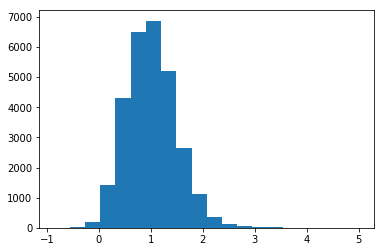

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

Посчитаем качество модели по метрике **nDCG**

In [42]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
)

score_lin_reg

0.827759744533848

Давайте теперь решим эту задачу не как регрессию, а как классификацию

In [0]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification


In [45]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train) 



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [0]:
prd = clf.predict(X_test)

In [48]:
prd

array([2, 2, 2, ..., 0, 0, 0])

In [49]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = prd
)

score_lin_reg

0.7882826383847911

#### Ранжируем с RandomForestRegressor

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [51]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
rfpred = regr.predict(X_test)

In [53]:
rfpred

array([1.02717979, 1.02717979, 0.99137591, ..., 1.50624088, 0.61383348,
       0.61750074])

In [55]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rfpred
)

score_lin_reg

0.7980941921805917

#### Ранжируем с XGBoost

In [0]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

param = {'objective':'multi:softmax', 'num_class': len(set(labels))}

In [70]:
num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-merror:0.514755	train-merror:0.461823
[1]	eval-merror:0.503117	train-merror:0.448332
[2]	eval-merror:0.498511	train-merror:0.441244
[3]	eval-merror:0.498234	train-merror:0.435573
[4]	eval-merror:0.488778	train-merror:0.430062
[5]	eval-merror:0.486492	train-merror:0.425473
[6]	eval-merror:0.485799	train-merror:0.419583
[7]	eval-merror:0.481089	train-merror:0.415402
[8]	eval-merror:0.479219	train-merror:0.410243
[9]	eval-merror:0.477833	train-merror:0.405507
[10]	eval-merror:0.477002	train-merror:0.401181
[11]	eval-merror:0.475928	train-merror:0.397863
[12]	eval-merror:0.473885	train-merror:0.393931
[13]	eval-merror:0.474889	train-merror:0.390438
[14]	eval-merror:0.471876	train-merror:0.386799
[15]	eval-merror:0.468066	train-merror:0.382209
[16]	eval-merror:0.467616	train-merror:0.379067
[17]	eval-merror:0.465919	train-merror:0.374609
[18]	eval-merror:0.466646	train-merror:0.370429
[19]	eval-merror:0.464568	train-merror:0.368426


In [0]:

preds = bst.predict(dtest)

In [72]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = preds
)

score_lin_reg

0.7985753289739121

#### Ранжируем с LightGBM

In [0]:
import lightgbm


In [78]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
clf = lgb.train(params, d_train, 100)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

[1]	valid_0's l2: 0.846519	valid_0's l1: 0.776381
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.8321	valid_0's l1: 0.768817
[3]	valid_0's l2: 0.819416	valid_0's l1: 0.762619
[4]	valid_0's l2: 0.807616	valid_0's l1: 0.757606
[5]	valid_0's l2: 0.797303	valid_0's l1: 0.753691
[6]	valid_0's l2: 0.78628	valid_0's l1: 0.749556
[7]	valid_0's l2: 0.776699	valid_0's l1: 0.746032
[8]	valid_0's l2: 0.76885	valid_0's l1: 0.7434
[9]	valid_0's l2: 0.761638	valid_0's l1: 0.740856
[10]	valid_0's l2: 0.753133	valid_0's l1: 0.737474
[11]	valid_0's l2: 0.747146	valid_0's l1: 0.735393
[12]	valid_0's l2: 0.742332	valid_0's l1: 0.733763
[13]	valid_0's l2: 0.737386	valid_0's l1: 0.732016
[14]	valid_0's l2: 0.73278	valid_0's l1: 0.730203
[15]	valid_0's l2: 0.727764	valid_0's l1: 0.728098
[16]	valid_0's l2: 0.722907	valid_0's l1: 0.725937
[17]	valid_0's l2: 0.716944	valid_0's l1: 0.723065
[18]	valid_0's l2: 0.712258	valid_0's l1: 0.72079
[19]	valid_0's l2: 0.708194	valid_0's 

In [79]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = y_pred
)

score_lin_reg

0.8294185834102193